Code writer: [Christian Benitez](https://github.com/christianmbr).

In [ ]:
# Librerias necesarias.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import cv2 as cv
import pickle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
# Definicion que procesa las imagenes de una serie de carpetas y generar un dataframe de pandas.
def prepareDataFrame(dir, imageSize, save=False, name=''):
  data = [] # Array donde se irán almacenado la informacion de las imagenes.
  # Ciclo que recorre todas las carpetas de un path de carpetas para procesar cada imagen.
  for folder in os.listdir(dir):
    folderPath = os.path.join(dir, folder)
    clase = int(folderPath[-1]) # La clase será el nombre de la carpeta.
    for imagen in os.listdir(folderPath):
      imgPath = os.path.join(folderPath, imagen)

      # Se procesa la imagen.
      # Se lee en escalas de grises.
      # Se redimenciona teniendo en cuenta la variable size.
      # Se aplana el arreglo a una dimension con ravel()
      # Se agrega la clase de la respectiva imagen en la posicion final del array. 
      img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
      img = cv.resize(img, (imageSize, imageSize))
      img = img.ravel()
      img = np.append(img, clase)

      data.append(img)
  # Todo el string con las imagenes se convierte en un DataFrame de pandas.
  dataFrame = pd.DataFrame(np.array(data))
  # Baraja el dataframe.
  dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)
  # Extraemos la columna final para ponerla en la posicion 0 (de primero)
  label = dataFrame.pop(imageSize * imageSize)
  dataFrame.insert(0, 'label', label)

  if (save == True):
    dataFrame.to_csv(f'{name}.csv')
    return 'Save success'

  return dataFrame

In [ ]:
# Funsion que resibe un prediccion y te devuelve el accuracy score y confusion matrix.
def createMetrics(prediction, yTest):
  yTest = np.argmax(yTest, axis= 1)
  prediction = np.argmax(prediction, axis= 1)

  acc = accuracy_score  (yTest, prediction) # Accuracy score.
  cm  = confusion_matrix(yTest, prediction) # Confussion matrix

  return acc, cm

In [ ]:
# Funsion para imprimir informacion de la base x, y.
def moreInfo(db):
  # Cargamos lables que están en la columna label.
  y = np.array(db.iloc[:, 0])
  # Cargamos las caracteristicas de la base de datos.
  x = np.array(db.iloc[:, 1:])

  print(f'Dimensiones de la imagen: {math.sqrt(x.shape[1])} x {math.sqrt(x.shape[1])}')
  print(f'Cantidad de muestras: {x.shape[0]}')
  print(f'Clases unicas: {np.unique(y)}')
  print(f'Numero de clases: {len(np.unique(y))}')

In [ ]:
def preparexyTrainTestSplit(db, nClases, dimension):
  x = np.array(db.iloc[: , 1:]) # Extraemos caracteristicas.
  y = np.array(db.iloc[: , 0]) # Extraemos labels.
  
  # Separamos datos de entrenamiento y prueba.
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=.2, random_state=154)
  print('Datos de entrenamiento', xTrain.shape[0])
  print('Datos de testeo', xTest.shape[0])

  # Categorizamos yTrain, yTest.
  yTrain = to_categorical(yTrain, nClases)
  yTest = to_categorical(yTest, nClases)

  # Reshape de los datos de enternamiento y testeo.
  xTrain = xTrain.reshape([-1, dimension, dimension, 1]).astype(float)
  xTest = xTest.reshape([-1, dimension, dimension, 1]).astype(float)

  # Convertimos los valores a 0 - 1
  xTrain /= 255
  xTest /= 255

  return xTrain, xTest, yTrain, yTest

In [ ]:
# Funsion para preparar x, y para el modelo neuronal. 
def preparexy(db, n_classes, dimensiones=(28, 28)):
  # Cargamos lables que están en la columna label.
  y = np.array(db.iloc[:, 0])
  # Categorizamos las 25 clases (señas).
  y = to_categorical(y, n_classes)

  # Cargamos las caracteristicas de la base de datos.
  x = np.array(db.iloc[:, 1:])
  # Reshape de los datos de enternamiento.
  x = x.reshape([-1, dimensiones[0], dimensiones[1], 1]).astype(float)
  # Convertimos los valores a 0 - 1
  x /= 255

  return x, y

In [ ]:
# Funsion que grafica el modelo.
def plotModel(model):
  # Plot progress (loss function)
  _, axes = plt.subplots(1,2, figsize=(15,5))
  axes[0].plot(model.history['loss'] , c = "orange", linestyle = "-" )
  axes[0].plot(model.history['val_loss'] , c = "green" , linestyle = "--")
  axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross Entropy")
  axes[0].set_title("Loss")

  axes[1].plot(model.history['accuracy'] , c = "orange", linestyle = "-" )
  axes[1].plot(model.history['val_loss'] , c = "green" , linestyle = "--")
  axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("Accuracy")
  axes[1].set_title("Accuracy")

In [ ]:
dir = './data_base/image_samples'

In [ ]:
db = prepareDataFrame(dir, imageSize=70)

In [ ]:
db[:3]

,label,0,1,2,3,4,5,6,7,8,...,4890,4891,4892,4893,4894,4895,4896,4897,4898,4899
0,0,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
1,3,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,67,67,67
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
moreInfo(db)

Dimensiones de la imagen: 70.0 x 70.0
Cantidad de muestras: 4000
Clases unicas: [0 1 2 3]
Numero de clases: 4


In [ ]:
x, y = preparexy(db, n_classes=4, dimensiones=(70, 70))

In [ ]:
x.shape

(4000, 70, 70, 1)

In [ ]:
# Creando el modelo.
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 1), padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(256, kernel_size = (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(524, kernel_size = (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten ())
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))

model.summary()

# Configurando el modelo.
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics= 'accuracy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

In [ ]:
# Entenamiento del modelo con muestras de entrenamiento.
history = model.fit(x, y, epochs = 250, batch_size = 15000, verbose = 1, validation_split = .1)

In [ ]:
plotModel(history)

In [ ]:
dirTest = '/content/drive/Othercomputers/Mi portátil/Universidad Semestres/Semestre 9/proyecto final inteligencia artificial/i/sampleTest'

In [ ]:
dbTest = prepareDataFrame(dirTest, imageSize=70)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
moreInfo(dbTest)

Dimensiones de la imagen: 70.0 x 70.0
Cantidad de muestras: 1600
Clases unicas: [0 1 2 3]
Numero de clases: 4


In [ ]:
xTest, yTest = preparexy(dbTest, 4, (70, 70))

In [ ]:
xTest.shape

(1600, 70, 70, 1)

In [ ]:
# Realizamos una prediccion con los valores de prueba.
prediction = model.predict(xTest)
# Sacamos las metricas.
acc, cm = createMetrics(prediction, yTest)

50/50 [==============================] - 0s 4ms/step


[Text(0.5, 1.0, 'Confussion matrix\nAccuracy test: 85.12%')]

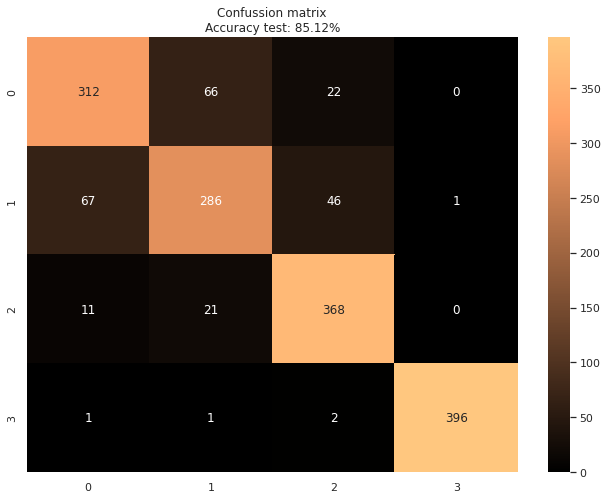

In [ ]:
sns.set(rc={'figure.figsize': (11, 8)})
sns.heatmap(cm, annot=True, cmap="copper", fmt='g').set(title=f'Confussion matrix\nAccuracy test: {acc:.2%}')

In [ ]:
pickle.dump(model, open('demensiaModel.pkl', 'wb'))

In [ ]:
for folder in os.listdir(dir):
  folderPath = os.path.join(dir, folder)
  clase = int(folderPath[-1]) # La clase será el nombre de la carpeta.
  for imagen in os.listdir(folderPath):
    imgPath = os.path.join(folderPath, imagen)

    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (70, 70))
    print(img.ravel())
    break
  break
    #
    #img = cv.resize(img, (70, 70))
    #img = img.ravel()
    #img = np.append(img, clase)

[17 17 17 ... 17 17 17]


# App

In [ ]:
class AppDetection:
  path  = '/demensiaModel.pkl'
  model = pickle.load(open(path, 'rb'))
  imagesBitMap = []
  pred = []

  def __init__(self, path):
    self.dir = path
    self.readFolder()

  def readFolder(self):
    self.imagesBitMap = []
    for folder in os.listdir(self.dir):
      folderPath = os.path.join(self.dir, folder)
      image = cv.imread(folderPath, cv.IMREAD_GRAYSCALE)
      image = cv.resize(image, (70, 70))
      image = image.ravel()
      self.imagesBitMap.append(image)

  def showImages(self):
    for image in self.imagesBitMap:
      plt.imshow(image.reshape([70, 70]), cmap='gray')
      plt.title('MRI')
      plt.axis('off')
      plt.show()

  def predict(self):
    self.pred = self.model.predict(np.array(self.imagesBitMap).reshape([-1 , 70, 70, 1]).astype(float))
    self.pred = np.argmax(self.pred, axis=1)
    # return self.pred
  
  def showResults(self):
    for i, bitMap in enumerate(self.imagesBitMap):
      if (self.pred[i] == 0):
        result = 'Non Demented'
      elif (self.pred[i] == 1):
        result = 'Very Mild Demented'
      elif (self.pred[i] == 2):
        result = 'Mild Demented'
      else:
        result = 'Moderate Demented'

      plt.figure(figsize=(15, 8))
      plt.imshow(bitMap.reshape([70, 70]), cmap='gray')
      plt.title(f'Dementia type: {result}')
      plt.axis('off')
      plt.show()

  def start(self):
    while(True):
      print('Welcome.')
      print('Show images: 1')
      print('Predict images: 2')
      print('Read images: 3')
      print('Finish: 0')
      print()
      selection = int(input('Select: '))

      if(selection == 1):
        print('Showing images')
        self.showImages()
      elif(selection == 2):
        self.predict()
        self.showResults()
      elif(selection == 3):
        self.readFolder()
        print('Images successfully read')
      else:
        print('Good bye')
        break

In [ ]:
app = AppDetection('image_folder')

Welcome.
Show images: 1
Predict images: 2
Read images: 3
Finish: 0

Select: 1
Showing images


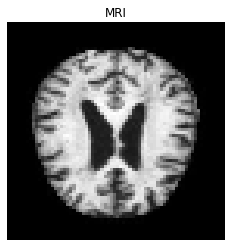

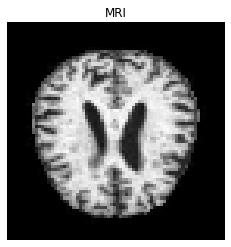

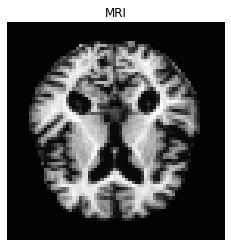

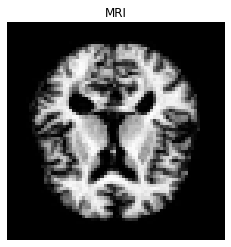

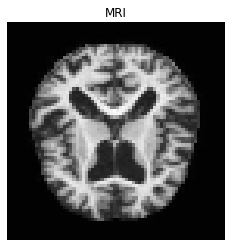

Welcome.
Show images: 1
Predict images: 2
Read images: 3
Finish: 0

Select: 2
1/1 [==============================] - 0s 112ms/step


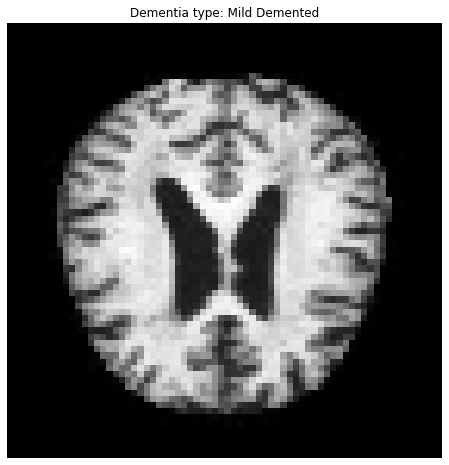

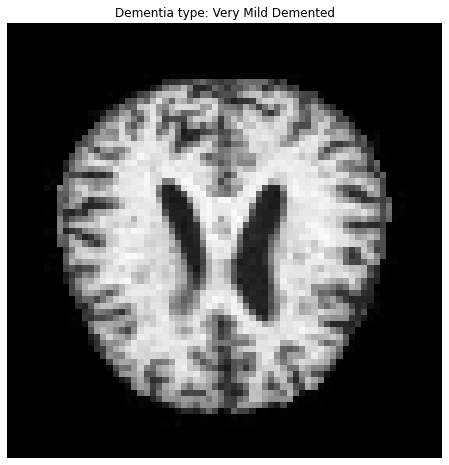

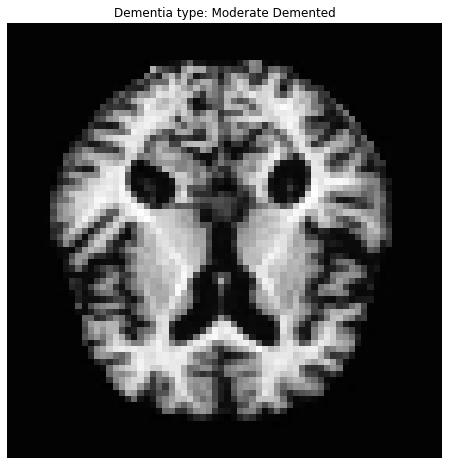

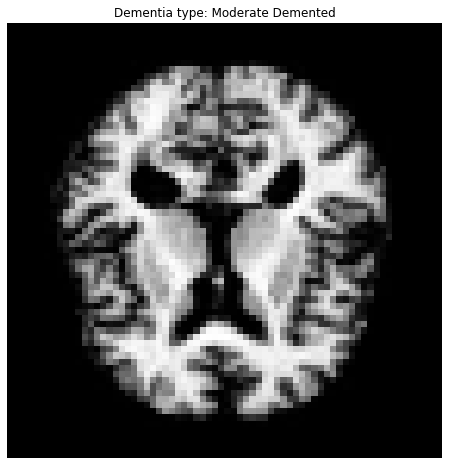

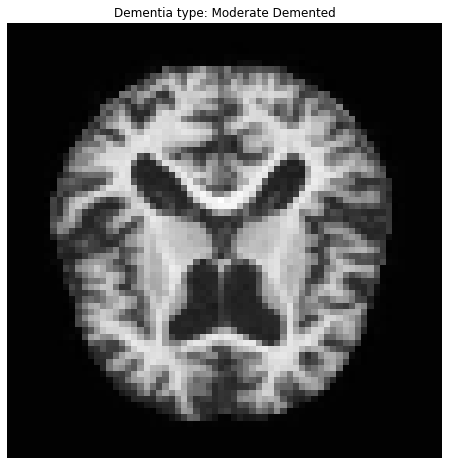

Welcome.
Show images: 1
Predict images: 2
Read images: 3
Finish: 0

Select: 0
Good bye


In [ ]:
app.start()